In [1]:
import numpy as np
import astropy
import math
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

unit_d_path = '/home1/10000/elee0506/unit_d.npy'
redshift_path = '/home1/10000/elee0506/redshift.npy'
unit_d = np.load(unit_d_path).astype(np.float32)
redshift = np.load(redshift_path).astype(np.float32)
output_num = '118'

## 1. Calculates the maximum value for the data in a 10% projection. 

In [3]:

data_points = [
    ("4.63", "118"),
    ("5.62", "090"),
    ("5.98", "082"),
    ("6.97", "065"),
    ("7.99", "052"),
    ("10.02", "034"),
    ("12.10", "023"),
    ("14.99", "014")]

# Iterate over redshift-outputnum pairs and the 'rec' type
for redshift, outputnum in data_points:
    rec_file_path = f'/home1/10000/elee0506/scratch/output_000{outputnum}/projection/10%projection_rec.npy'
    rec = np.load(rec_file_path).astype(np.float64)
    quantity = rec / 819  # Normalize if needed

    # Find the maximum value of the quantity
    max_quantity = np.max(quantity)
    print(f"Output {outputnum} - max: {max_quantity}")

Output 118 - max: 1.924132113287435e-26
Output 090 - max: 4.314659213584256e-26
Output 082 - max: 9.543897754278283e-26
Output 065 - max: 5.452582304244396e-26
Output 052 - max: 2.9515628570497217e-26
Output 034 - max: 1.461517397822275e-26
Output 023 - max: 7.342682148992489e-27
Output 014 - max: 7.401181627195353e-27


## 2. Produces the projection figure for the rec/col/total in 8 given snaps, and saves them to the corresponding paths. Produced figures are used to produce animation (step 3).

In [3]:
%%time  
data_points = [
    ("4.63", "118"),
    ("5.62", "090"),
    ("5.98", "082"),
    ("6.97", "065"),
    ("7.99", "052"),
    ("10.02", "034"),
    ("12.10", "023"),
    ("14.99", "014")]

# Define the types to iterate over
types = ['rec', 'col', 'sum']

# Iterate over redshift-outputnum pairs and types
for redshift, outputnum in data_points:
    
    for type in types:
        # Load data based on the 'type' & divide by 819 (cells) to account for projection depth being different depending on redshift
        if type == 'col':
            col = np.load(f'/home1/10000/elee0506/scratch/output_000{outputnum}/projection/10%projection_col.npy').astype(np.float64)
            quantity = col / (819)
        elif type == 'rec':
            rec = np.load(f'/home1/10000/elee0506/scratch/output_000{outputnum}/projection/10%projection_rec.npy').astype(np.float64)
            quantity = rec / (819)
        elif type == 'sum':
            rec = np.load(f'/home1/10000/elee0506/scratch/output_000{outputnum}/projection/10%projection_rec.npy').astype(np.float64)
            col = np.load(f'/home1/10000/elee0506/scratch/output_000{outputnum}/projection/10%projection_col.npy').astype(np.float64)
            sum_data = rec + col
            quantity = sum_data / (819)

        file = quantity 
        vmin = -35.5
        vmax = -28.5

        # Replace zeros or invalid values with NaN
        file_with_nan = np.where(file > 0, file, np.nan)

        normalize1 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        colormap1 = mpl.colormaps['afmhot']

        # Create figure with constrained layout
        fig = plt.figure(figsize=(7, 7), dpi=500, constrained_layout=True)
        ax1 = fig.subplots(nrows=1, ncols=1)

        # Set black background for the axes
        ax1.set_facecolor('black')

        # Plotting the image with a black background for invalid values
        im = ax1.imshow(
            np.log10(file_with_nan).T,
            cmap=plt.cm.afmhot,
            vmin=vmin,
            vmax=vmax,
            extent=[0, 94.43, 0, 94.43],
            interpolation='none'
        )

        # Scalar mappable for colorbar
        scalarmappaple = mpl.cm.ScalarMappable(norm=normalize1, cmap=colormap1)
        cbar = fig.colorbar(scalarmappaple, ax=ax1, fraction=0.046, pad=0.04, aspect=22)
        cbar.set_label(label=r'Luminosity density [erg/s/cm$^3$]', fontsize=15)

        # Set axis labels
        ax1.set_xlabel('$x$ [cMpc]', fontsize=15)
        ax1.set_ylabel('$y$ [cMpc]', fontsize=15)

        ax1.set_xlim(0, 94.43)
        ax1.set_ylim(0, 94.43)

        # Generate uniform tick positions
        num_ticks = 5  # Number of ticks including start and end
        x_ticks = np.linspace(0, 94.43, num_ticks)  # Uniformly spaced ticks for x-axis
        y_ticks = np.linspace(0, 94.43, num_ticks)  # Uniformly spaced ticks for y-axis

        # Set ticks on axes
        ax1.set_xticks(x_ticks)
        ax1.set_yticks(y_ticks)

        # Add minor ticks
        ax1.minorticks_on()
        # Customize minor ticks (optional)
        ax1.tick_params(axis='both', which='minor', length=4, width=1, direction='in')
        # Customize major ticks (optional)
        ax1.tick_params(axis='both', which='major', length=7, width=1.5, direction='in', labelsize=13)

        #cbar.ax.tick_params(labelsize=15)  # Increase font size of colorbar ticks using ax
        ax1.text(4, 87.5, f'z = {redshift}', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        
        # Save the figure as a JPG file
        save_path = f'/home1/10000/elee0506/scratch/output_000{outputnum}/projection/{type}_proj.jpg'
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
        plt.close(fig)  # Close the figure to save memory

CPU times: user 3min 29s, sys: 43.9 s, total: 4min 12s
Wall time: 4min 16s


## 3. Produces the animation of luminosity density evolution (rec/col/total) based on the saved figures to corresponding redshifts. vmin/vmax values are manually adjustable.

CPU times: user 3min 20s, sys: 2.47 s, total: 3min 23s
Wall time: 3min 45s


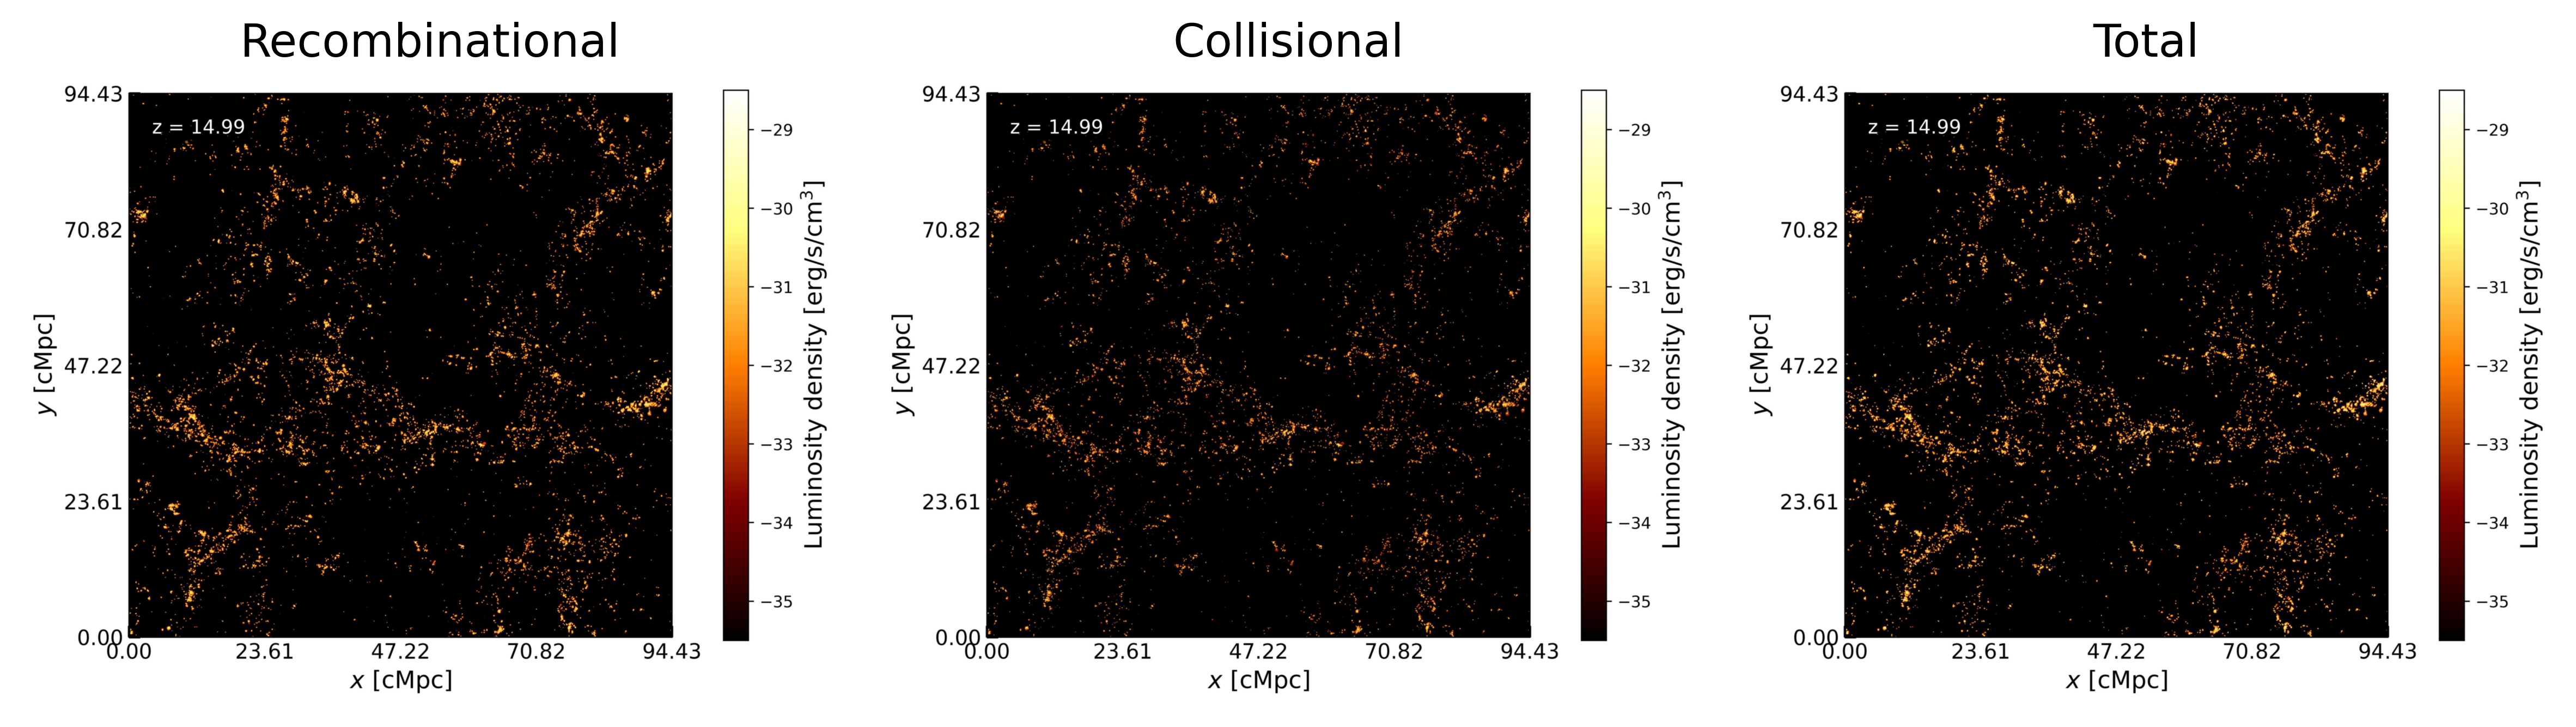

In [4]:
%%time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# Define parameters
outputnums = ['014', '023', '034', '052', '065', '082', '090', '118']  # Ordered from 014 to 118
types = ['rec', 'col', 'sum']  # Column order: rec, col, sum
base_path = '/home1/10000/elee0506/scratch/output_000'

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=400)

# Reduce spacing between columns
plt.subplots_adjust(wspace=0.05)  # Adjust spacing between subplots

# Titles for the columns
titles = ['Recombinational', 'Collisional', 'Total']
for j, title in enumerate(titles):
    axes[j].set_title(title, fontsize=15)

# Turn off axes initially
for ax in axes:
    ax.axis('off')

# Function to update the frames in the animation
def update(frame):
    outputnum = outputnums[frame]
    for j, t in enumerate(types):
        # Construct the file path
        file_path = f'{base_path}{outputnum}/projection/{t}_proj.jpg'
        # Load and display the image
        if os.path.exists(file_path):
            img = mpimg.imread(file_path)
            axes[j].imshow(img, interpolation='bicubic', cmap='viridis')  # Apply smooth interpolation and colormap
            axes[j].axis('off')  # Turn off axes
        else:
            axes[j].text(0.5, 0.5, 'Image not found', fontsize=12, ha='center', va='center')
            axes[j].axis('off')

# Create the animation
anim = FuncAnimation(fig, update, frames=len(outputnums), interval=1000, repeat=True)

# Save the animation as a GIF using PillowWriter with imagemagick backend
output_path = '/home1/10000/elee0506/scratch/projection_evolution.gif'
anim.save(output_path, writer='imagemagick', fps=1, dpi=400)  # No need for 'palette' argument